In [1]:
!pip install scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

In [3]:
!unzip "archive (4).zip"


Archive:  archive (4).zip
  inflating: data.csv                


In [4]:
!ls


'archive (4).zip'   data.csv   sample_data


In [6]:
data = pd.read_csv("data.csv", encoding="latin1")


/tmp/ipython-input-3656042244.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv", encoding="latin1")


In [7]:
print(data.head())
print(data.shape)


  stn_code       sampling_date           state   location agency  \
0    150.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1    151.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2    152.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3    150.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4    151.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  1990-02-01  
1                         NaN    NaN  1990-02-01  
2                         NaN    NaN  1990-02-01  
3       

In [8]:
data = pd.read_csv("data.csv", encoding="latin1")


data = data[["no2"]].dropna()

x = data["no2"].values.reshape(-1, 1)

print("NO2 data shape:", x.shape)


/tmp/ipython-input-4153102150.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv", encoding="latin1")


NO2 data shape: (419509, 1)


In [10]:
r = 102303735

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("Roll No:", r)
print("a_r =", a_r)
print("b_r =", b_r)

x_transformed = a_r * x + b_r

Roll No: 102303735
a_r = 1.0
b_r = 0.3


In [11]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x_transformed)

real_data = torch.tensor(x_scaled, dtype=torch.float32)

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [14]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), lr=0.001)
d_optimizer = optim.Adam(D.parameters(), lr=0.001)

In [15]:
epochs = 1500   # safe & fast for Colab
batch_size = 64

for epoch in range(epochs):

    idx = np.random.randint(0, real_data.shape[0], batch_size)
    real_samples = real_data[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

In [17]:
for epoch in range(epochs):

    idx = np.random.randint(0, real_data.shape[0], batch_size)
    real_samples = real_data[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)


    z = torch.randn(batch_size, 5)
    fake_samples = G(z)

    d_real = D(real_samples)
    d_fake = D(fake_samples.detach())

    d_loss = criterion(d_real, real_labels) + criterion(d_fake, fake_labels)

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()


    z = torch.randn(batch_size, 5)
    fake_samples = G(z)
    d_fake = D(fake_samples)

    g_loss = criterion(d_fake, real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch % 300 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 0 | D Loss: 1.4088 | G Loss: 0.6267
Epoch 300 | D Loss: 1.3919 | G Loss: 0.6878
Epoch 600 | D Loss: 1.3770 | G Loss: 0.6959
Epoch 900 | D Loss: 1.4236 | G Loss: 0.6678
Epoch 1200 | D Loss: 1.3793 | G Loss: 0.6944


In [18]:
z = torch.randn(2000, 5)
generated_samples = G(z).detach().numpy()
generated_samples = scaler.inverse_transform(generated_samples)


In [19]:
kde = gaussian_kde(generated_samples.flatten())
x_range = np.linspace(
    generated_samples.min(),
    generated_samples.max(),
    500
)
pdf_values = kde(x_range)


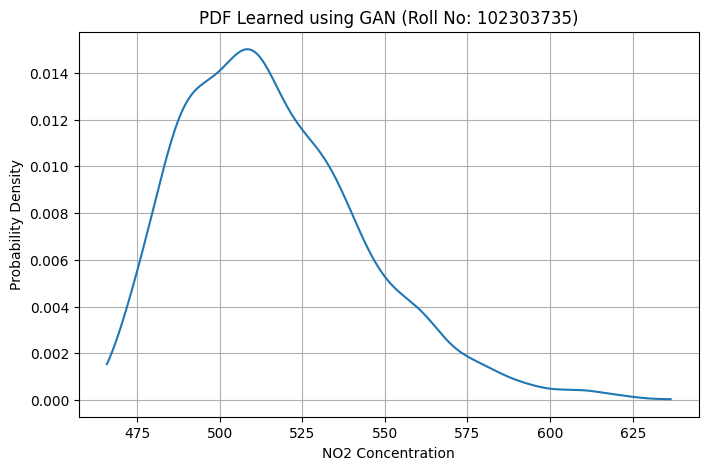

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(x_range, pdf_values)
plt.xlabel("NO2 Concentration")
plt.ylabel("Probability Density")
plt.title("PDF Learned using GAN (Roll No: 102303735)")
plt.grid(True)
plt.show()


In [21]:
print("=== Transformation Parameters ===")
print(f"a_r = {a_r}")
print(f"b_r = {b_r}")

=== Transformation Parameters ===
a_r = 1.0
b_r = 0.3
